In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr 13 11:34:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/[CV]_MADiff-T

/content/drive/MyDrive/[CV]_MADiff-T


In [5]:
!pip install kagglehub torch torchvision pillow numpy matplotlib transformers timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00


In [ ]:
import kagglehub
import os, zipfile
from glob import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
import json
from tqdm import tqdm

In [ ]:
# Tải dataset
drive_path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

# Nếu là file .zip thì giải nén
if os.path.isfile(drive_path) and drive_path.endswith('.zip'):
    extract_path = '/content/celeba_hq_256'
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(drive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    drive_path = extract_path

# Trỏ tới thư mục chứa ảnh
image_dir = os.path.join(drive_path, 'celeba_hq_256')
image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
print(f"✅ Đã giải nén và tìm thấy {len(image_paths)} ảnh tại: {image_dir}")

✅ Đã giải nén và tìm thấy 30000 ảnh tại: /kaggle/input/celebahq-resized-256x256/celeba_hq_256


In [ ]:
CAPTION_PATH = "caption_map1.json"
NUM_BLIP_CAPTIONS = 3000
SAVE_INTERVAL = 20

# BLIP setup
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def blip_caption(path):
    try:
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)
        out = model.generate(**inputs)
        return processor.decode(out[0], skip_special_tokens=True)
    except:
        return None

# Caption ngẫu nhiên
adjectives = ["smiling", "serious", "young", "old", "beautiful", "handsome", "confident", "shy"]
genders = ["man", "woman", "person"]
extras = ["with glasses", "wearing a hat", "with earrings", "with long hair", "with short hair", "looking left", "looking forward"]

def random_caption():
    return f"a {random.choice(adjectives)} {random.choice(genders)} {random.choice(extras)}"

# Load cache nếu có
if os.path.exists(CAPTION_PATH):
    with open(CAPTION_PATH, "r") as f:
        caption_map = json.load(f)
else:
    caption_map = {}

# Sinh caption
for i, path in enumerate(tqdm(image_paths)):
    fname = os.path.basename(path)
    if fname in caption_map:
        continue

    if i < NUM_BLIP_CAPTIONS:
        cap = blip_caption(path)
        if cap:
            caption_map[fname] = cap
            continue

    caption_map[fname] = random_caption()

    if i % SAVE_INTERVAL == 0:
        with open(CAPTION_PATH, "w") as f:
            json.dump(caption_map, f, indent=2)

# Save cuối
with open(CAPTION_PATH, "w") as f:
    json.dump(caption_map, f, indent=2)

print(f"📄 Đã tạo caption cho {len(caption_map)} ảnh → lưu tại {CAPTION_PATH}")

100%|██████████| 30000/30000 [00:00<00:00, 342153.82it/s]


📄 Đã tạo caption cho 30000 ảnh → lưu tại caption_map1.json


In [ ]:
import torch
from transformers import T5Tokenizer, T5EncoderModel
from tqdm import tqdm

def precompute_text_embeddings(caption_map, output_path="text_embeddings.pt", text_model_name="t5-small"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = T5Tokenizer.from_pretrained(text_model_name)
    text_encoder = T5EncoderModel.from_pretrained(text_model_name).encoder.to(device).eval()

    embeddings = {}
    with torch.no_grad():
        for fname, caption in tqdm(caption_map.items(), desc="Precomputing text embeddings"):
            tokens = tokenizer(caption, return_tensors="pt", padding=True, truncation=True, max_length=20).to(device)
            embed = text_encoder(**tokens).last_hidden_state.mean(dim=1).cpu()  # [1, 512]
            embeddings[fname] = embed.squeeze(0)
    torch.save(embeddings, output_path)
    return embeddings

# Load caption map từ file của bạn
CAPTION_PATH = "caption_map1.json"
with open(CAPTION_PATH, "r") as f:
    caption_map = json.load(f)

# Precompute embeddings
if not os.path.exists("text_embeddings.pt"):
    text_embeddings = precompute_text_embeddings(caption_map)
else:
    text_embeddings = torch.load("text_embeddings.pt")

In [ ]:
class CelebAHQCaptionDataset(Dataset):
    def __init__(self, root_dir, caption_map, text_embeddings, transform=None, mask_size=128):
        self.root_dir = root_dir
        self.caption_map = caption_map  # Giữ lại để debug nếu cần
        self.text_embeddings = text_embeddings  # Thêm text embeddings
        self.transform = transform
        self.mask_size = mask_size
        self.image_files = [f for f in os.listdir(root_dir) if f.lower().endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        fname = self.image_files[idx]
        img_path = os.path.join(self.root_dir, fname)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        mask = torch.ones(1, image.shape[1], image.shape[2])
        h, w = image.shape[1], image.shape[2]
        top = np.random.randint(0, h - self.mask_size)
        left = np.random.randint(0, w - self.mask_size)
        mask[:, top:top+self.mask_size, left:left+self.mask_size] = 0
        masked_image = image * mask

        text_embed = self.text_embeddings[fname]  # Lấy embedding pre-computed
        return masked_image, mask, image, text_embed

# Transform ảnh
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Tạo Dataset & DataLoader
dataset = CelebAHQCaptionDataset(
    root_dir=image_dir,
    caption_map=caption_map,
    text_embeddings=text_embeddings,
    transform=transform,
    mask_size=128
)

train_loader = DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True  # Tăng batch size lên 8
)

In [ ]:
for masked_img, mask, gt_img, text_embed in train_loader:
    print("🖼️ Masked image:", masked_img.shape)
    print("🎭 Mask:", mask.shape)
    print("📷 Ground truth:", gt_img.shape)
    print("📝 Text embed:", text_embed.shape)
    # In caption gốc để đối chiếu
    batch_fnames = [dataset.image_files[i] for i in range(len(masked_img))]
    captions = [dataset.caption_map[fname] for fname in batch_fnames]
    print("📝 Original Captions:", captions[:4])  # In 4 caption đầu tiên
    print("📝 Text Embeddings:", text_embed[:4])  # In 4 embedding đầu tiên
    break

🖼️ Masked image: torch.Size([8, 3, 256, 256])
🎭 Mask: torch.Size([8, 1, 256, 256])
📷 Ground truth: torch.Size([8, 3, 256, 256])
📝 Text embed: torch.Size([8, 512])
📝 Original Captions: ['a young man wearing a hat', 'a smiling person wearing a hat', 'a old man looking forward', 'a handsome man looking left']
📝 Text Embeddings: tensor([[-0.0808,  0.0512, -0.0702,  ...,  0.0272, -0.0780, -0.0481],
        [-0.0313,  0.0431, -0.0182,  ..., -0.0246, -0.0573, -0.0373],
        [-0.0723,  0.0461, -0.0270,  ...,  0.0307, -0.0620, -0.1175],
        [-0.1305,  0.0983, -0.0859,  ...,  0.0227, -0.0842,  0.0029]])


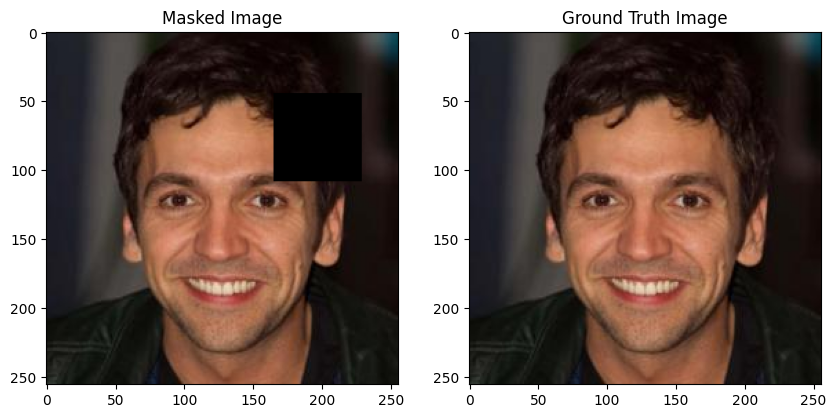

Caption: a beautiful person with glasses


In [ ]:
# prompt: show random 1 sample với caption bên dưới

import matplotlib.pyplot as plt
import random

# Chọn ngẫu nhiên một sample từ train_loader
random_index = random.randint(0, len(dataset) - 1)
masked_img, mask, gt_img, text_embed = dataset[random_index]

# Hiển thị ảnh
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(masked_img.permute(1, 2, 0)) # Convert tensor to image
plt.title("Masked Image")

plt.subplot(1, 2, 2)
plt.imshow(gt_img.permute(1, 2, 0)) # Convert tensor to image
plt.title("Ground Truth Image")

plt.show()

# In caption tương ứng
fname = dataset.image_files[random_index]
caption = dataset.caption_map[fname]
print(f"Caption: {caption}")


# Mô hình MADiff-T

In [ ]:
from transformers import T5Tokenizer, T5EncoderModel
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🚀 Using device:", device)

tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_encoder = T5EncoderModel.from_pretrained("t5-small").eval().to(device)

@torch.no_grad()
def encode_prompt(prompt_list):
    tokens = tokenizer(prompt_list, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = t5_encoder(**tokens)
    embed = outputs.last_hidden_state.mean(dim=1)  # [B, 512]
    return embed

🚀 Using device: cuda


In [ ]:
class MaskedContextEncoder(nn.Module):
    def __init__(self, image_size=256, patch_size=16, in_channels=4, embed_dim=256, depth=4, nhead=8):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (image_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

    def forward(self, image, mask):
        x = torch.cat([image, mask], dim=1)  # [B, 4, 256, 256]
        x = self.patch_embed(x)  # [B, embed_dim, 16, 16]
        B, D, H_p, W_p = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, 256, embed_dim]

        patch_mask = F.interpolate(mask, size=(H_p, W_p), mode="nearest").flatten(2).transpose(1, 2)  # [B, 256, 1]
        patch_mask = (patch_mask < 0.5).float()  # 1 cho vùng bị mask

        # Lọc chỉ patch bị mask
        masked_x = []
        masked_pos = []
        for b in range(B):
            mask_b = patch_mask[b].bool().squeeze(-1)  # [256]
            masked_x.append(x[b][mask_b])
            masked_pos.append(self.pos_embed[0][mask_b])
        max_len = max(x.shape[1] for x in masked_x) if masked_x else 1  # Tránh lỗi khi không có patch bị mask
        padded_x = torch.zeros(B, max_len, D, device=x.device)
        padded_pos = torch.zeros(B, max_len, D, device=x.device)
        for b in range(B):
            padded_x[b, :len(masked_x[b])] = masked_x[b]
            padded_pos[b, :len(masked_pos[b])] = masked_pos[b]

        x = padded_x + padded_pos
        x = self.transformer(x)  # [B, max_len, embed_dim]
        return x

In [ ]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, embed_dim=256, text_dim=512):  # Thêm text_dim
        super().__init__()
        self.text_proj = nn.Linear(text_dim, embed_dim)  # Project text từ 512 về 256
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )

    def forward(self, image_tokens, text_embedding):
        B = image_tokens.size(0)
        text_embedding = self.text_proj(text_embedding).unsqueeze(1)  # [B, 512] -> [B, 256] -> [B, 1, 256]
        attn_output, _ = self.attention(image_tokens, text_embedding, text_embedding)  # [B, L_masked, 256]
        attn_output = self.norm(attn_output + image_tokens)
        output = self.norm(self.ffn(attn_output) + attn_output)
        return output

In [ ]:
class LightUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_c)
            )
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dec2 = conv_block(128 + 64, 64)
        self.dec1 = nn.Conv2d(64, out_channels, 3, padding=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d2 = self.dec2(torch.cat([self.up(e2), e1], dim=1))
        return self.dec1(d2)

class DiffusionDecoder(nn.Module):
    def __init__(self, token_dim=256, text_dim=512, out_channels=3, img_size=512, patch_size=16):
        super().__init__()
        self.token_dim = token_dim
        self.patch_size = patch_size
        self.img_size = img_size
        self.num_patches = (img_size // patch_size) ** 2

        self.latent_tokens = nn.Parameter(torch.randn(1, self.num_patches, token_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, token_dim))
        self.text_proj = nn.Linear(text_dim, token_dim)

        decoder_layer = nn.TransformerDecoderLayer(d_model=token_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=4)
        self.to_latent = nn.Linear(token_dim, patch_size * patch_size * out_channels)
        self.unet = LightUNet()

    def forward(self, context_token, text_embed):
        B = context_token.size(0)
        x = self.latent_tokens.expand(B, -1, -1) + self.pos_embed  # [B, 256, token_dim]
        text = self.text_proj(text_embed).unsqueeze(1)  # [B, 1, token_dim]

        # Padding context_token để khớp với latent_tokens
        if context_token.size(1) < self.num_patches + 1:
            pad_size = self.num_patches + 1 - context_token.size(1)
            padding = torch.zeros(B, pad_size, self.token_dim, device=context_token.device)
            mem = torch.cat([context_token, padding, text], dim=1)
        else:
            mem = torch.cat([context_token, text], dim=1)

        x = self.transformer(x, mem)
        x = self.to_latent(x)
        x = x.view(B, 16, 16, 3, self.patch_size, self.patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(B, 3, self.img_size, self.img_size)
        return self.unet(x)

In [ ]:
class MADiffTModel(nn.Module):
    def __init__(self, encoder, decoder, cross_attn):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cross_attn = cross_attn

    def forward(self, masked_img, mask, text_embed):
        context_token = self.encoder(masked_img, mask)  # [B, L_masked, D]
        context_token = self.cross_attn(context_token, text_embed)  # [B, L_masked, D]
        out = self.decoder(context_token, text_embed)  # [B, 3, H, W]
        return out

In [ ]:
from torchvision.models import vgg16

vgg = vgg16(pretrained=True).features[:16].eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

def normalize_for_vgg(img):
    return (img - mean) / std

def total_inpainting_loss(output, target, mask, λ=0.8):
    if mask.shape[1] == 1:
        mask = mask.expand(-1, 3, -1, -1)

    l1 = F.l1_loss(output * mask, target * mask)
    percept = F.l1_loss(vgg(normalize_for_vgg(output * mask)), vgg(normalize_for_vgg(target * mask)))
    return λ * l1 + (1 - λ) * percept

In [ ]:
from torch import amp  # Thay vì torch.cuda.amp

# Khởi tạo mô hình
encoder = MaskedContextEncoder()
decoder = DiffusionDecoder()
cross_attn = CrossAttentionBlock(embed_dim=256, text_dim=512)
model = MADiffTModel(encoder, decoder, cross_attn).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = amp.GradScaler('cuda')  # Cập nhật cách khởi tạo GradScaler
num_epochs = 30
best_loss = float('inf')
best_ckpt_path = "best_checkpoint.pth"

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        masked_img, mask, target_img, text_embed = batch
        masked_img, mask, target_img, text_embed = masked_img.to(device), mask.to(device), target_img.to(device), text_embed.to(device)

        with amp.autocast('cuda'):  # Cập nhật autocast
            output = model(masked_img, mask, text_embed)
            loss = total_inpainting_loss(output, target_img, mask)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    print(f"💡 Avg loss @ epoch {epoch+1}: {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_ckpt_path)
        print(f"✅ Saved best checkpoint with loss {best_loss:.4f}")

# Load checkpoint tốt nhất
model.load_state_dict(torch.load(best_ckpt_path))
model.eval()
print("✅ Đã load checkpoint tốt nhất để đánh giá.")

Epoch 1/30: 100%|██████████| 3750/3750 [12:30<00:00,  5.00it/s, loss=0.338]


💡 Avg loss @ epoch 1: 0.3470
✅ Saved best checkpoint with loss 0.3470


Epoch 2/30:  32%|███▏      | 1215/3750 [04:04<08:39,  4.88it/s, loss=0.313]

In [ ]:
!pip install torchmetrics --quiet
# Cài đặt torch-fidelity
!pip install torch-fidelity --quiet

In [ ]:
# Cài đặt torch-fidelity nếu chưa có
!pip install torch-fidelity --quiet

from torchmetrics.functional import structural_similarity_index_measure as ssim
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
import torch
import json
import os

def evaluate(model, dataloader, device, num_samples=None):
    """
    Đánh giá mô hình trên tập dữ liệu với SSIM, PSNR và FID.

    Args:
        model: Mô hình đã huấn luyện (MADiffTModel)
        dataloader: DataLoader chứa dữ liệu đánh giá
        device: Thiết bị chạy (cuda/cpu)
        num_samples: Số mẫu để đánh giá (None nếu dùng toàn bộ dataloader)

    Returns:
        dict: Chứa các chỉ số SSIM, PSNR, FID
    """
    model.eval()
    total_ssim = 0
    total_psnr = 0
    fid_metric = FrechetInceptionDistance(feature=64).to(device)
    count = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="🔍 Evaluating"):
            masked_img, mask, target_img, text_embed = batch
            masked_img = masked_img.to(device)
            mask = mask.to(device)
            target_img = target_img.to(device)
            text_embed = text_embed.to(device)

            # Forward qua mô hình
            output = model(masked_img, mask, text_embed)

            # Đảm bảo giá trị trong khoảng [0, 1] cho SSIM và PSNR
            output = output.clamp(0, 1)
            target_img = target_img.clamp(0, 1)

            # Tính SSIM và PSNR
            total_ssim += ssim(output, target_img, data_range=1.0).item()
            total_psnr += psnr(output, target_img, data_range=1.0).item()

            # Chuẩn bị cho FID: Chuyển sang uint8 (0-255)
            output_uint8 = (output * 255).byte()
            target_uint8 = (target_img * 255).byte()
            fid_metric.update(target_uint8, real=True)
            fid_metric.update(output_uint8, real=False)

            count += 1
            if num_samples and count >= num_samples:
                break

    # Tính trung bình SSIM, PSNR và FID
    avg_ssim = total_ssim / count
    avg_psnr = total_psnr / count
    fid_score = fid_metric.compute().item()

    # Reset FID metric
    fid_metric.reset()

    # In kết quả
    print(f"📊 Evaluation Metrics:")
    print(f"   SSIM: {avg_ssim:.4f}")
    print(f"   PSNR: {avg_psnr:.2f} dB")
    print(f"   FID : {fid_score:.2f}")

    return {
        "ssim": avg_ssim,
        "psnr": avg_psnr,
        "fid": fid_score
    }

def save_metrics(metrics, save_path="evaluation_metrics.json", format="json"):
    """
    Lưu các chỉ số đánh giá vào file.

    Args:
        metrics: Dictionary chứa các chỉ số (ssim, psnr, fid)
        save_path: Đường dẫn file để lưu
        format: Định dạng lưu ('json' hoặc 'txt')
    """
    if format == "json":
        # Lưu dưới dạng JSON
        with open(save_path, "w") as f:
            json.dump(metrics, f, indent=4)
        print(f"💾 Metrics saved to {save_path} in JSON format")
    elif format == "txt":
        # Lưu dưới dạng TXT
        with open(save_path, "w") as f:
            f.write("Evaluation Metrics:\n")
            f.write(f"SSIM: {metrics['ssim']:.4f}\n")
            f.write(f"PSNR: {metrics['psnr']:.2f} dB\n")
            f.write(f"FID : {metrics['fid']:.2f}\n")
        print(f"💾 Metrics saved to {save_path} in TXT format")
    else:
        raise ValueError("Unsupported format. Use 'json' or 'txt'.")

# Ví dụ sử dụng
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_loader = train_loader  # Thay bằng val_loader nếu có tập validation riêng

# Đánh giá mô hình
metrics = evaluate(model, val_loader, device, num_samples=100)

# Lưu chỉ số
save_metrics(metrics, save_path="evaluation_metrics.json", format="json")
# Hoặc lưu dưới dạng TXT
save_metrics(metrics, save_path="evaluation_metrics.txt", format="txt")